# Final Project on Supervised Learning

### LAN and WAN Response Analysis 
- Description: The source of our data comes from the variablity of a LAN network when it is connecting to the Internet. The data is collected by the ping response time from the devices of the local internet router and to the first-hop server on the internet.
- Group Members: Eric Topmiller, Viphu Nguyen, David Gigremosa, Paul Rozario

Question to Answer: What is the worst time of day for ping response with ethernet and wireless for both LAN and WAN?

In [27]:

# Import libraries

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn import preprocessing
import matplotlib.pyplot as plt
from matplotlib import style

In [28]:
# Set the dataset from the network csv
df = pd.read_csv('ping_data_rp829c7e0e_eth.csv')
df.head()
df.sort_values('timestamp', inplace=True)

### Data Wrangling and Filtering the Data
- Done by Viphu Nguyen and Eric Topmiller

In [29]:
# Finding the missing values from the ping dataset
df.isna().sum()

timestamp      0
location       0
source         0
local_dest     0
local_avg      0
remote_dest    0
remote_avg     0
dtype: int64

In [30]:
# Duplicate the dataframe in case of crashes
df1 = df.copy()

In [31]:
# Removing unncessary columns from the ping dataset
df1 = df1.drop(['location', 'local_dest', 'remote_dest'], axis = 1)
df1

,timestamp,source,local_avg,remote_avg
0,1.559041e+09,ethernet,0.19,8.14
1,1.559041e+09,ethernet,0.15,7.75
2,1.559041e+09,ethernet,0.15,8.68
3,1.559041e+09,ethernet,0.15,8.08
4,1.559041e+09,ethernet,0.15,8.20
...,...,...,...,...
69740,1.559691e+09,ethernet,0.15,8.70
69741,1.559691e+09,ethernet,0.15,8.43
69742,1.559691e+09,ethernet,0.15,8.71
69743,1.559691e+09,ethernet,0.15,8.42


#### *Each header definition*
- Timestamp: The current time of an event that is recorded
- Source: Network Source
- Local_avg: Response Time for local network (ms)
- Remote_avg: Response time for remote network (ms)

In [32]:
# create a column that is the start of the range of hours of the day, show the head, show it has all 24 hours of the day
#df1['hour'] = (df['timestamp'].astype(int) % 86400) / 14400
df1['hour'] = (df['timestamp'].astype(int) % 86400) / 3600
df1['hour'] = df1['hour'].astype(int)
print(df1.head())
df1['hour'].unique()
print(df1.info())

      timestamp    source  local_avg  remote_avg  hour
0  1.559041e+09  ethernet       0.19        8.14    10
1  1.559041e+09  ethernet       0.15        7.75    10
2  1.559041e+09  ethernet       0.15        8.68    10
3  1.559041e+09  ethernet       0.15        8.08    10
4  1.559041e+09  ethernet       0.15        8.20    10
<class 'pandas.core.frame.DataFrame'>
Int64Index: 69745 entries, 0 to 69744
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   timestamp   69745 non-null  float64
 1   source      69745 non-null  object 
 2   local_avg   69745 non-null  float64
 3   remote_avg  69745 non-null  float64
 4   hour        69745 non-null  int32  
dtypes: float64(3), int32(1), object(1)
memory usage: 2.9+ MB
None


In [33]:
# find the quartiles of the time data so we can create local average categorical variable
print(df1['local_avg'].max())
print(df1['remote_avg'].max())
print(df1)

9999.9999
9999.9999
          timestamp    source  local_avg  remote_avg  hour
0      1.559041e+09  ethernet       0.19        8.14    10
1      1.559041e+09  ethernet       0.15        7.75    10
2      1.559041e+09  ethernet       0.15        8.68    10
3      1.559041e+09  ethernet       0.15        8.08    10
4      1.559041e+09  ethernet       0.15        8.20    10
...             ...       ...        ...         ...   ...
69740  1.559691e+09  ethernet       0.15        8.70    23
69741  1.559691e+09  ethernet       0.15        8.43    23
69742  1.559691e+09  ethernet       0.15        8.71    23
69743  1.559691e+09  ethernet       0.15        8.42    23
69744  1.559691e+09  ethernet       0.15        9.12    23

[69745 rows x 5 columns]


count    64290.000000
mean         0.403038
std         18.790955
min          0.140000
25%          0.150000
50%          0.150000
75%          0.150000
max       2000.000000
Name: local_avg, dtype: float64
count    64290.000000
mean        11.971681
std         31.553788
min          4.020000
25%          8.150000
50%          8.540000
75%          9.200000
max       2000.000000
Name: remote_avg, dtype: float64


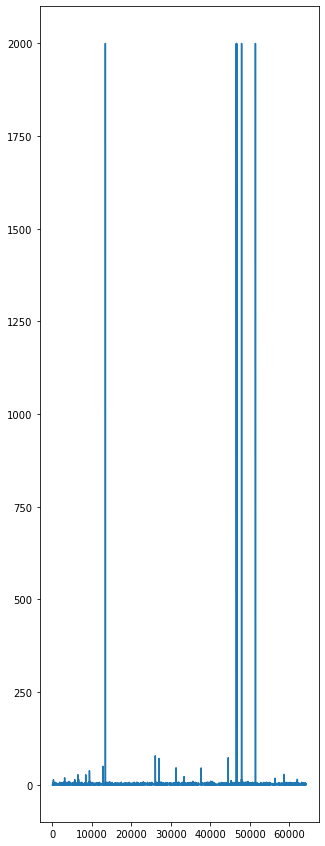

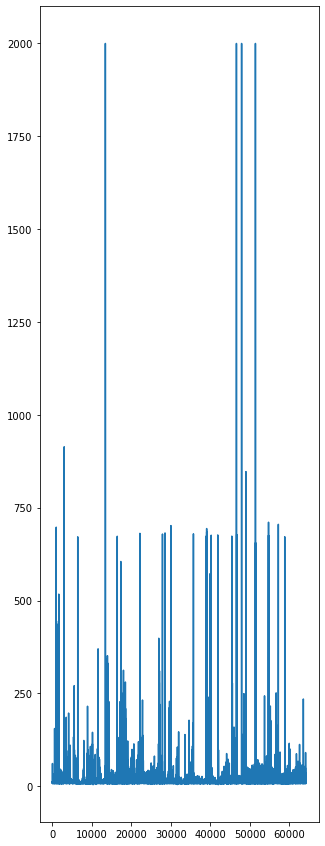

In [34]:
# remove the rows with avg of 9999.9999 since they are failures and will skew the data
df1 = df1[(df1['local_avg'] != 9999.9999) & (df1['remote_avg'] != 9999.9999)]
df1 = df1.reset_index()
print(df1['local_avg'].describe())
print(df1['remote_avg'].describe())
df1['local_avg'].plot(figsize=(5,15))
plt.show()
df1['remote_avg'].plot(figsize=(5,15))
plt.show()

In [35]:
# create the categorical variable local_delay for the local delay of low, average, high
# we will leave in the 9999.9999 since they probably represent failures and should be placed the high
#bins = [float('-inf'), 0.149, 0.151, float('inf')]
bins = [float('-inf'), 0.149, 0.15, float('inf')]
labels = ['Small', 'Medium', 'Large']
df1['local_delay'] = pd.cut(df1['local_avg'], bins=bins, labels=labels)
df1.head()
print(df1['local_delay'].unique())


['Large', 'Medium', 'Small']
Categories (3, object): ['Small' < 'Medium' < 'Large']


In [36]:
# find the quartiles of the time data so we can create local average categorical variable
print(df1['remote_avg'].describe())


count    64290.000000
mean        11.971681
std         31.553788
min          4.020000
25%          8.150000
50%          8.540000
75%          9.200000
max       2000.000000
Name: remote_avg, dtype: float64


In [37]:
# create the categorical variable local_delay for the remote delay of low, average, high
# we will leave in the 9999.9999 since they probably represent failures and should be placed the high
bins = [float('-inf'), 8.15, 9.2, float('inf')]
labels = ['Small', 'Medium', 'Large']
df1['remote_delay'] = pd.cut(df1['remote_avg'], bins=bins, labels=labels)
df1.head()
print(df1['local_delay'].unique())


['Large', 'Medium', 'Small']
Categories (3, object): ['Small' < 'Medium' < 'Large']


In [38]:
# do a categorical variable for ismean for the local_avg because we have a lot
# of them
df1['ismean'] = 0
df1.loc[df1["local_avg"] == 0.15, "ismean"] = 1

In [39]:
# do a categorical variable for large remote_avg greater than 1000 ms
df1['big_remote_avg'] = 0
df1.loc[df1['remote_avg'] >= 1000.0, "big_remote_avg"] = 1

### Data Visualizations 
- Done by Viphu Nguyen

count    64290.000000
mean         0.403038
std         18.790955
min          0.140000
25%          0.150000
50%          0.150000
75%          0.150000
max       2000.000000
Name: local_avg, dtype: float64

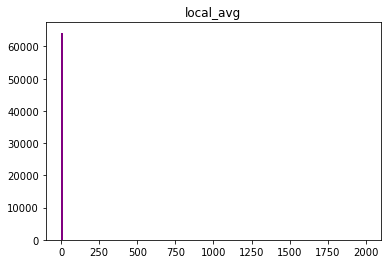

In [40]:
# Histogram for 'local_avg' response time (local) column
df1.hist(column='local_avg', bins=200, grid=False, rwidth=.9, color='purple')
df1['local_avg'].describe()

count    64290.000000
mean        11.971681
std         31.553788
min          4.020000
25%          8.150000
50%          8.540000
75%          9.200000
max       2000.000000
Name: remote_avg, dtype: float64

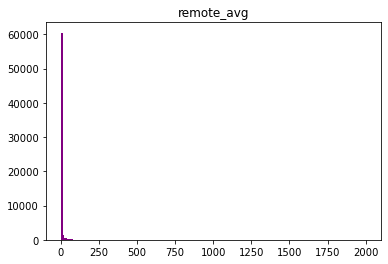

In [41]:
# Histogram for 'remote_avg' response time (local) column
df1.hist(column='remote_avg', bins=200, grid=False, rwidth=.9, color='purple')
df1['remote_avg'].describe()

Analysis: The histogram tells us that the the response time (ms) is estimated largely between 0 to 2,000 while there is a fewer amount at closer to 10,000 frequency for the response time between 8,000 to 10,000

In [42]:
# Duplicate the dataframe in case of crashes
df2 = df1.copy()

In [43]:
# map the local_delay and remote_delay to integers since that is what is needed by the classifier
df2['local_delay_int'] = df2['local_delay'].map({'Small':0, 'Medium':1, 'Large':2}).astype(int)
df2['remote_delay_int'] = df2['remote_delay'].map({'Small':0, 'Medium':1, 'Large':2}).astype(int)
print(df2['local_delay_int'].unique())
print(df2['remote_delay_int'].unique())
X = df2.drop(['index', 'timestamp', 'source', 'local_avg', 'remote_avg', 'local_delay', 'remote_delay', 'hour'], axis = 1)
y = df2['hour']
print(X.head())
print(y.head())

[2 1 0]
[0 1 2]
   ismean  big_remote_avg  local_delay_int  remote_delay_int
0       0               0                2                 0
1       1               0                1                 0
2       1               0                1                 1
3       1               0                1                 0
4       1               0                1                 1
0    10
1    10
2    10
3    10
4    10
Name: hour, dtype: int32


In [44]:
# split out the test and train datasets
X_train, X_test, y_train, y_test= train_test_split(X, y,test_size=0.2,random_state=99)
print(X_train, y_train)

       ismean  big_remote_avg  local_delay_int  remote_delay_int
37688       1               0                1                 1
28698       1               0                1                 0
4298        1               0                1                 1
34934       1               0                1                 1
22472       1               0                1                 2
...       ...             ...              ...               ...
42697       1               0                1                 1
36008       1               0                1                 0
46265       1               0                1                 1
23587       1               0                1                 0
29313       0               0                2                 2

[51432 rows x 4 columns] 37688    20
28698    19
4298     23
34934    13
22472     2
         ..
42697    10
36008    16
46265    20
23587     5
29313    21
Name: hour, Length: 51432, dtype: int32


### Use scikit-learn for Logistic Regression and DecisionTree Classification, XGBoost, Keras, Pytorch to train, test and predict a categorical variable. Use appropriate metric and interpret themeaning of the score

### Logistic Regression

In [45]:
LogReg = LogisticRegression()

scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

LogReg.fit(X_train,y_train)

y_pred=LogReg.predict(X_test)

In [46]:
print('Classes', LogReg.classes_)
print('Intercept',LogReg.intercept_)
print("Coefficients", LogReg.coef_ )

Classes [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Intercept [-0.14099822 -0.18836825 -0.21448302 -0.08903546 -0.03757543 -0.04334061
 -0.11135342 -0.1250854  -0.14170459 -0.07996194 -0.10877586  0.08761892
  0.1158005   0.10849218  0.10684393  0.114739    0.11129795  0.11036097
  0.10089179  0.09886773  0.09048997  0.11614667  0.07751222  0.04162037]
Coefficients [[-0.04055158  0.08611368 -0.04831843  0.43655501]
 [-0.0118884   0.07212947  0.02927055  0.54693529]
 [ 0.10377955 -0.0231805   0.08635539  0.60275449]
 [-0.05444766 -0.01955955 -0.0698966   0.34599745]
 [-0.00673453 -0.01501846  0.0227079  -0.06273091]
 [-0.06004416 -0.0130072  -0.06857011 -0.2059365 ]
 [-0.10072869 -0.01081767 -0.10570279 -0.395942  ]
 [ 0.00430619 -0.01016198 -0.04121537 -0.42316961]
 [ 0.14684639 -0.00998008  0.13484092 -0.465906  ]
 [-0.03988571 -0.01110067 -0.08301843 -0.35491699]
 [-0.00978051 -0.01071131 -0.02892566 -0.39769254]
 [-0.08092499  0.08111144 -0.07403231 -0.

In [47]:
print("Accuracy", LogReg.score(X_test, y_test))
print(classification_report(y_test, LogReg.predict(X_test)))

Accuracy 0.05949603359776015
              precision    recall  f1-score   support

           0       1.00      0.00      0.00       532
           1       0.07      0.08      0.08       524
           2       0.09      0.44      0.14       520
           3       0.00      0.00      0.00       501
           4       0.00      0.00      0.00       512
           5       0.00      0.00      0.00       486
           6       0.11      0.00      0.00       515
           7       0.00      0.00      0.00       521
           8       0.07      0.44      0.12       517
           9       0.00      0.00      0.00       478
          10       0.00      0.00      0.00       529
          11       0.00      0.00      0.00       564
          12       0.00      0.00      0.00       536
          13       0.00      0.00      0.00       556
          14       0.00      0.00      0.00       556
          15       0.04      0.41      0.08       540
          16       0.00      0.00      0.00       55

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Decision Tree
- Done by Viphu Nguyen and Eric Topmiller

In [48]:
clf = DecisionTreeClassifier(criterion='entropy', random_state=99)

In [49]:
clf.fit(X_train,y_train)
y_pred= clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.06081816767771037

##### Plot a Decision Tree

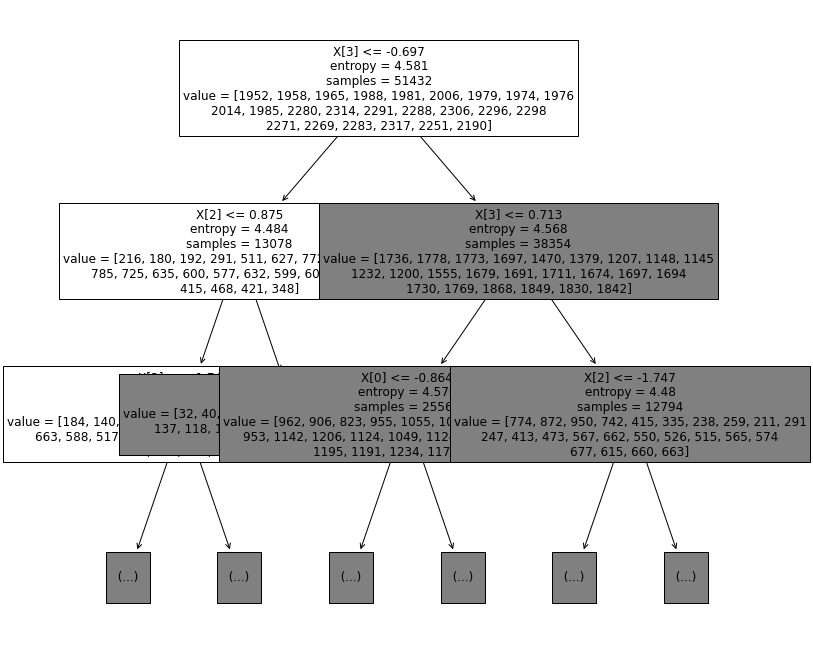

In [50]:
fig, ax = plt.subplots(figsize=(12, 12))
tree.plot_tree(decision_tree=clf, max_depth= 2,fontsize=12);

###  Show feature importance in XGBoost by using xgb.plot.importance

In [51]:
!pip install xgboost
import xgboost as xgb
xg_cl = xgb.XGBClassifier(objective='binary:logistic', max_depth=10, n_estimators=20, seed=99) 
xg_cl.fit(X_train, y_train)
preds = xg_cl.predict(X_test)
accuracy = float(np.sum(preds==y_test))/y_test.shape[0]
print("accuracy: %f" % (accuracy))

accuracy: 0.060429


## Keras

In [52]:
#!pip install tensorflow --user
#from tensorflow.keras import layers, losses
#from tensorflow.keras.datasets import fashion_mnist
#from tensorflow.keras.models import Model

### Compare the results of the algorithms (comparison, conclusion, challenges...etc.)

### Outcome of our analysis